## Dataset Prep

In [24]:
ied_path = "Datasets/IIITH-IED"
sep_path = "Datasets/SEP28K"

In [25]:
from pathlib import Path
import os

def get_ied_filled_pauses():
    paths = []
    for wav_path in Path(ied_path).rglob("*.wav"):
        tag = wav_path.stem
        tag = tag[tag.find("_") + 1: ]
        if tag in ['F', 'F2', 'F3', 'F4']:
            paths.append(str(wav_path))
    return paths

def get_sep_filled_pauses():
    return [str(path) for path in Path(os.path.join(sep_path, "Interjection")).iterdir()]

In [26]:
ied_data = get_ied_filled_pauses()
len(ied_data)

868

In [27]:
sep_data = get_sep_filled_pauses()
len(sep_data)

5187

## Feature Extraction

In [28]:
import librosa
from prosody import get_prosody_features
# import python_speech_features as psf
from tqdm import tqdm

def get_features(wav, fs):
    # feats = psf.mfcc(wav, samplerate=fs, numcep=13, winlen=0.02)
    feats = get_prosody_features(wav, fs)
    return feats

def get_features_from_paths(paths):
    features = []
    for path in tqdm(paths):
        wav, fs = librosa.load(path)
        features.append({
            'path': path,
            'features': get_features(wav, fs),
            'length': wav.shape[0] / fs
        })
    return features

In [29]:
ied_feats = get_features_from_paths(ied_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [13:59<00:00,  1.03it/s]


In [ ]:
sep_feats = get_features_from_paths(sep_data)

In [8]:
import pickle as pkl

with open("feature_dump", 'wb') as f:
    pkl.dump({
        'ied_feats': ied_feats,
        'sep_feats': sep_feats
    }, f)

In [6]:
import pickle as pkl

with open("feature_dump", 'rb') as f:
    data = pkl.load(f)
    ied_feats = data['ied_feats']
    sep_feats = data['sep_feats']

## Filtering

In [7]:
ied_length = 0
for ied in ied_feats:
    ied_length += ied['length']
print(ied_length, len(ied_feats))

9143.999773242635 868


In [8]:
sep_length = 0
for ind, sep in enumerate(sep_feats):
    sep_length += sep['length']
    if sep_length > ied_length:
        break
sep_feats = sep_feats[: ind]
print(sep_length, len(sep_feats))

9144.0 3047


In [19]:
def get_audio_pair(path):
    features = get_features_from_paths([path])[0]['features']
    if path.find(ied_path) >= 0:
        labels = np.full((features.shape[0], ), 0)
    else:
        labels = np.full((features.shape[0], ), 1)
    return features, labels

## Models

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

def conf_mat(labels_gt, labels_pred):
    cm = confusion_matrix(labels_gt, labels_pred)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

def get_analysis(labels_gt, labels_pred):
    print("precision", precision_score(labels_gt, labels_pred))
    print("recall", recall_score(labels_gt, labels_pred))
    print("accuracy", accuracy_score(labels_gt, labels_pred))
    conf_mat(labels_gt, labels_pred)

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

ied_feats_ = np.vstack([ied['features'] for ied in ied_feats])[: 20000, :]
sep_feats_ = np.vstack([sep['features'] for sep in sep_feats])[: 20000, :]
ied_labels = np.full((ied_feats_.shape[0], ), 0)
sep_labels_ = np.full((sep_feats_.shape[0], ), 1)
print(ied_feats_.shape, sep_feats_.shape, ied_labels.shape, sep_labels_.shape)

feats = np.vstack([ied_feats_, sep_feats_])
labels = np.hstack([ied_labels, sep_labels_])
feats_svm_train, feats_svm_test, labels_svm_train, labels_svm_test = train_test_split(feats, labels, test_size=1000)
print(feats_svm_train.shape, feats_svm_test.shape, labels_svm_train.shape, labels_svm_test.shape)

(20000, 13) (20000, 13) (20000,) (20000,)
(39000, 13) (1000, 13) (39000,) (1000,)


In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(feats_svm_train, feats_svm_test, labels_svm_train, labels_svm_test)

print(models)

 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 11/29 [00:17<00:17,  1.03it/s]

In [1]:
from sklearn import svm

svm_mfcc = svm.SVC(kernel='rbf', C=0.025)
svm_mfcc.fit(feats_svm_train, labels_svm_train)
# labels_svm_pred = svm_mfcc.predict(feats_svm_train)
# get_analysis(labels_svm_train, labels_svm_pred)
labels_svm_pred = svm_mfcc.predict(feats_svm_test)
get_analysis(labels_svm_test, labels_svm_pred)

NameError: name 'feats_svm_train' is not defined

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.30it/s]
/home2/parvathipriyanka.b/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision 0.0
recall 0.0
accuracy 0.8327759197324415
[[249  50]
 [  0   0]]


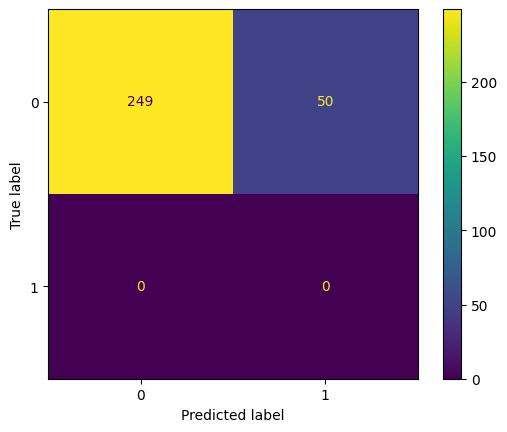

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1]


In [42]:
# f_, l_ = get_audio_pair("/home2/parvathipriyanka.b/ssp23/Datasets/IIITH-IED/data/28/28_F.wav")
f_, l_ = get_audio_pair("/home2/parvathipriyanka.b/ssp23/Datasets/SEP28K/Interjection/WomenWhoStutter_16_11.wav")
lp_ = svm_mfcc.predict(f_)
get_analysis(l_, lp_)
print(l_[:100])
print(lp_[:100])

precision 0.9461206896551724
recall 0.9014373716632443
accuracy 0.927
[[488  25]
 [ 48 439]]


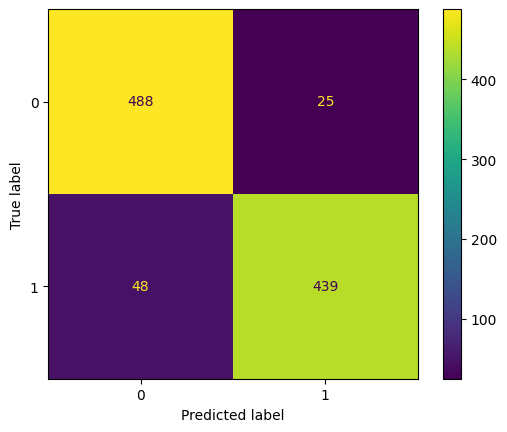

In [12]:
from sklearn.ensemble import RandomForestClassifier

rand_mfcc = RandomForestClassifier(random_state=5)
rand_mfcc.fit(feats_svm_train, labels_svm_train)
labels_svm_pred = rand_mfcc.predict(feats_svm_test)
get_analysis(labels_svm_test, labels_svm_pred)

In [13]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Sequential

def create_dense_nn(inp_shape):
    model = Sequential()
    model.add(Input(shape=(inp_shape, )))
    model.add(Dense(30, activation='sigmoid'))
    model.add(Dense(20, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

2023-11-20 13:08:03.450517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 13:08:17.136921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
neural_mfcc = create_dense_nn(13)
print(neural_mfcc.summary())
neural_mfcc.fit(feats_svm_train, labels_svm_train, epochs=25, batch_size=64)

2023-11-20 13:08:33.111772: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1261 (4.93 KB)
Trainable params: 1261 (4.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
610/610 [==============================] - 1s 1ms/step - loss: 0.7073 - accuracy: 0.4932
Epoch 2/25
610/610 [==============================]

32/32 [==============================] - 0s 1ms/step
precision 0.8431771894093686
recall 0.8501026694045175
accuracy 0.85
[[436  77]
 [ 73 414]]


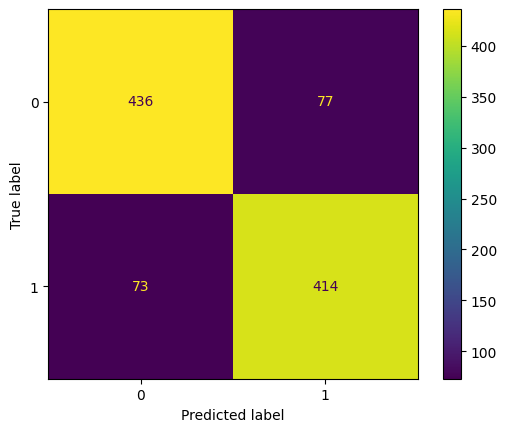

In [15]:
labels_svm_pred = (neural_mfcc.predict(feats_svm_test) > 0.5).astype("int16")
get_analysis(labels_svm_test, labels_svm_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.81it/s]

39/39 [==============================] - 0s 1ms/step



/home2/parvathipriyanka.b/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision 0.0
recall 0.0
accuracy 0.2797716150081566
[[343 883]
 [  0   0]]


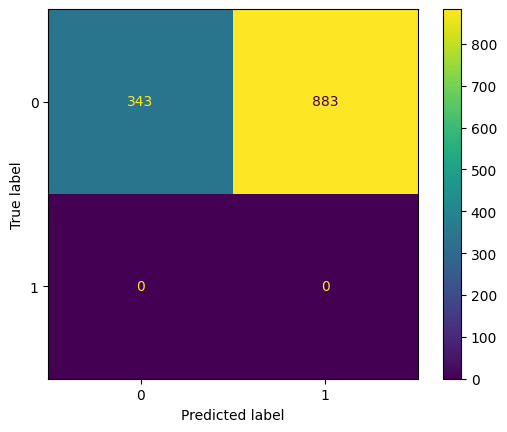

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


In [23]:
f_, l_ = get_audio_pair("/home2/parvathipriyanka.b/ssp23/Datasets/IIITH-IED/data/28/28_F.wav")
# f_, l_ = get_audio_pair("/home2/parvathipriyanka.b/ssp23/Datasets/SEP28K/Interjection/WomenWhoStutter_16_11.wav")
lp_ = (neural_mfcc.predict(f_) > 0.5).astype("int16")
get_analysis(l_, lp_)
print(l_[:100])
print(lp_[:100])